In [4]:
# import libraries
import numpy as np
import pandas as pd
import pickle
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Tuple
from pathlib import Path
from torch.utils.data import DataLoader

from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.nh_run import start_run, eval_run
from neuralhydrology.utils.config import Config


In [5]:
mpl.rcParams["grid.color"] = "#eeeeee"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 11})

### Train model with negative logarithm of the likelihood

In [6]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("DE_4_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("DE_4_basin.yml"), gpu=-1)

2024-12-04 14:00:41,114: Logging to /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/daily/single_basin_multi_forcing_MDN/DE4_riefensbeek_soese/runs/single_basin_multi_forcing_mdn_0412_140041/output.log initialized.
2024-12-04 14:00:41,114: ### Folder structure created at /home/sngrj0hn/GitHub/neuralhydrology/camels_harz/daily/single_basin_multi_forcing_MDN/DE4_riefensbeek_soese/runs/single_basin_multi_forcing_mdn_0412_140041
2024-12-04 14:00:41,115: ### Run configurations for single_basin_multi_forcing_mdn
2024-12-04 14:00:41,115: experiment_name: single_basin_multi_forcing_mdn
2024-12-04 14:00:41,115: train_basin_file: basin.txt
2024-12-04 14:00:41,115: validation_basin_file: basin.txt
2024-12-04 14:00:41,115: test_basin_file: basin.txt
2024-12-04 14:00:41,115: train_start_date: 1951-01-01 00:00:00
2024-12-04 14:00:41,115: train_end_date: 2015-09-30 00:00:00
2024-12-04 14:00:41,116: validation_start_date: 2015-10-01 00:00:00
2024-12-04 14:00:41,116: validation_end_date: 2018-09-30 0

### Evaluate run on test set
The path to the best model is automatically saved in the variable best_model, and the corresponding best epoch is stored as a string in best_epoch.

In [8]:
run_dir = Path("runs/single_basin_multi_forcing_mdn_0412_140041")
eval_run(run_dir=run_dir, period="test")

2024-12-04 14:26:02,281: Using the model weights from runs/single_basin_multi_forcing_mdn_0412_140041/model_epoch075.pt
# Evaluation: 100%|██████████| 1/1 [00:05<00:00,  5.36s/it]
2024-12-04 14:26:07,644: Stored metrics at runs/single_basin_multi_forcing_mdn_0412_140041/test/model_epoch075/test_metrics.csv
2024-12-04 14:26:07,652: Stored results at runs/single_basin_multi_forcing_mdn_0412_140041/test/model_epoch075/test_results.p


### Load and inspect model predictions
Load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [9]:
with open(run_dir / "test" / "model_epoch075" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['DE4'])

In [10]:
results['DE4']['1D']['xr']['discharge_vol_sim']

<xarray.DataArray 'discharge_vol_sim' (date: 823, time_step: 1, samples: 7500)>
array([[[0.05893439, 0.06131768, 0.05922371, ..., 0.1010561 ,
         0.07165354, 0.05304497]],

       [[0.06230843, 0.07198077, 0.06681532, ..., 0.08939862,
         0.07611096, 0.06382859]],

       [[0.08384871, 0.12160254, 0.09238738, ..., 0.0873878 ,
         0.08656013, 0.08398658]],

       ...,

       [[0.45663273, 0.3823447 , 0.56373924, ..., 0.5444329 ,
         0.46365738, 0.5973449 ]],

       [[0.4464357 , 0.36150104, 0.32072902, ..., 0.30673546,
         0.5211478 , 0.27735606]],

       [[0.34668162, 0.2407999 , 0.34607756, ..., 0.3967654 ,
         0.39216784, 0.3563197 ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 2018-10-01 2018-10-02 ... 2020-12-31
  * time_step  (time_step) int64 0
Dimensions without coordinates: samples

In [11]:
# Extract observations and simulations
qobs = results['DE4']['1D']['xr']['discharge_vol_obs']
qsim = results['DE4']['1D']['xr']['discharge_vol_sim']

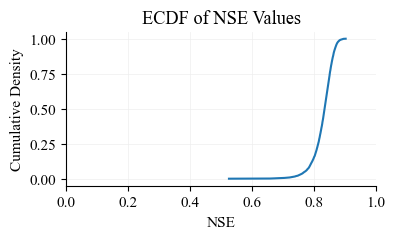

In [12]:
# Define the NSE calculation function
def nse(obs, sim):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE) between observed and simulated data.
    
    Parameters:
    obs (np.ndarray): Observed data array of shape (823,)
    sim (np.ndarray): Simulated data array of shape (823,)
    
    Returns:
    float: NSE value
    """
    # Ensure inputs are 1D numpy arrays
    obs = np.asarray(obs).flatten()
    sim = np.asarray(sim).flatten()
    
    # Calculate numerator and denominator for NSE
    denominator = np.sum((obs - np.mean(obs))**2)
    numerator = np.sum((sim - obs)**2)
    
    # Calculate NSE
    value = 1 - numerator / denominator
    return value

# Load or assign the observed data (shape: 823 x 1)
# Replace '...' with your actual data loading code
obs_data = qobs  # xarray.DataArray of shape (823, 1)
obs = obs_data.values.flatten()  # Convert to 1D numpy array of shape (823,)

# Load or assign the simulated data (shape: 823 x 1 x 1000)
# Replace '...' with your actual data loading code
sim_data = qsim  # xarray.DataArray of shape (823, 1, 1000)

# Number of samples (should be 1000)
num_samples = sim_data.shape[2]

# Initialize a list to store NSE values
nse_values = []

# Loop over each sample to calculate NSE
for i in range(num_samples):
    # Extract simulated data for the i-th sample (shape: 823,)
    sim_sample = sim_data[:, 0, i]
    
    # Calculate NSE between observed data and simulated sample
    nse_i = nse(obs, sim_sample)
    
    # Append the NSE value to the list
    nse_values.append(nse_i)

# Convert the list of NSE values to a numpy array
nse_values = np.array(nse_values)

# Sort the NSE values in ascending order
nse_sorted = np.sort(nse_values)

# Calculate cumulative probabilities for the ECDF
cum_probs = np.arange(1, len(nse_sorted) + 1) / len(nse_sorted)

# Plot the ECDF
plt.figure(figsize=(4, 2))
plt.plot(nse_sorted, cum_probs, linestyle='-')
plt.xlabel('NSE')
plt.ylabel('Cumulative Density')
plt.title('ECDF of NSE Values')
plt.xlim(0, 1)
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

In [13]:
cudalstm_config = Config(Path("DE_4_basin.yml"))

# create a new model instance with random weights
cuda_lstm = CudaLSTM(cfg=cudalstm_config)

# load the trained weights into the new model. 
model_path = run_dir / 'model_epoch075.pt'
model_weights = torch.load(str(model_path), map_location='cpu')  # load the weights from the file, creating the weight tensors on CPU
cuda_lstm.load_state_dict(model_weights)  # set the new model's weights to the values loaded from file
cuda_lstm

CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(12, 256)
  (dropout): Dropout(p=0.2, inplace=False)
  (head): CMAL(
    (fc1): Linear(in_features=256, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=12, bias=True)
    (_softplus): Softplus(beta=2, threshold=20.0)
  )
)

In [14]:
# make sure we're in eval mode where dropout is deactivated
cuda_lstm.eval()

# load the dataset
scaler = load_scaler(run_dir)
dataset = get_dataset(cudalstm_config, is_train=False, period='test', scaler=scaler)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=dataset.collate_fn)

cudalstm_output = []
# no need to calculate any gradients since we're just running some evaluations
with torch.no_grad():
    for sample in dataloader:
        cudalstm_output.append(cuda_lstm(sample))

print('CudaLSTM output:  ', list(cudalstm_output[0].keys()))

CudaLSTM output:   ['lstm_output', 'h_n', 'c_n', 'mu', 'b', 'tau', 'pi']


In [15]:
print('CudaLSTM shape:  ', cudalstm_output[0]['pi'].shape)  # [batch size, sequence length, number of mixture components]

CudaLSTM shape:   torch.Size([256, 365, 3])


In [16]:
# Concatenate all batches into one tensor that contains the final time step of each sample.
mix_comp_weights = torch.cat([out['pi'][:, -1, :] for out in cudalstm_output], dim=0)

# Load the forcings input for the corresponding date range
date_range = pd.date_range(cudalstm_config.test_start_date, cudalstm_config.test_end_date, freq='1D')

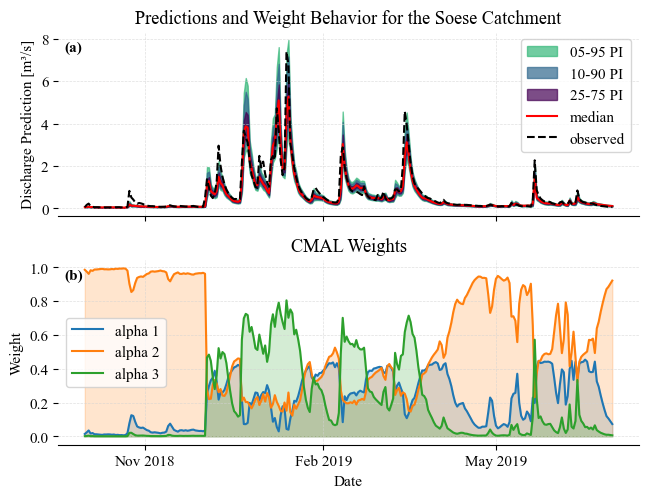

In [19]:
# Define the restricted date range
start_date = '2018-10-01'
end_date = '2019-06-30'


# Set up the plotting area with specified dimensions
figwidth = 17 # cm
figheight = 13 # cm

def cm2inch(width: float, height: float) -> Tuple[float, float]:
    """Converts figure size from centimeters to inch."""
    inch = 2.54
    return (width / inch, height / inch)


# Filter date_range and corresponding data
mask = (date_range >= start_date) & (date_range <= end_date)
date_range_filtered = date_range[mask]
qsim_filtered = qsim[mask, :]
qobs_filtered = qobs[mask]
mix_comp_weights_filtered = mix_comp_weights[mask, :]

# Create the subplot with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=cm2inch(figwidth, figheight), sharex=True)

# First subplot (Predictions)
y_median = np.median(qsim_filtered, axis=-1).flatten()
y_25 = np.percentile(qsim_filtered, 25, axis=-1).flatten()
y_75 = np.percentile(qsim_filtered, 75, axis=-1).flatten()
y_10 = np.percentile(qsim_filtered, 10, axis=-1).flatten()
y_90 = np.percentile(qsim_filtered, 90, axis=-1).flatten()
y_05 = np.percentile(qsim_filtered, 5, axis=-1).flatten()
y_95 = np.percentile(qsim_filtered, 95, axis=-1).flatten()

# Plotting in the first subplot
ax1.fill_between(date_range_filtered, y_05, y_95, color='#35B779', label='05-95 PI', alpha=0.7)
ax1.fill_between(date_range_filtered, y_10, y_90, color='#31688E', label='10-90 PI', alpha=0.7)
ax1.fill_between(date_range_filtered, y_25, y_75, color="#440154", label='25-75 PI', alpha=0.7)
ax1.plot(date_range_filtered, y_median, '-', color='red', label="median")
ax1.plot(date_range_filtered, qobs_filtered, '--', color='black', label="observed")

# Format the x-ticks and remove unnecessary spines
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Month Year'
for spine in ['top', 'right', 'left']:
    ax1.spines[spine].set_visible(False)

# Axis labels, title, grid, and legend for ax1
ax1.set_ylabel('Discharge Prediction [m³/s]')
ax1.legend()
ax1.set_title('Predictions and Weight Behavior for the Soese Catchment')
ax1.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.text(0.01, 0.95, "(a)", transform=ax1.transAxes, verticalalignment='top', fontweight='bold')

# Second subplot (CMAL weights)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Define color palette
for i in range(mix_comp_weights_filtered.shape[1]):
    ax2.plot(date_range_filtered, mix_comp_weights_filtered[:, i], label=f'alpha {i+1}', color=colors[i])
    ax2.fill_between(date_range_filtered, 0, mix_comp_weights_filtered[:, i], color=colors[i], alpha=0.2)

# Remove unnecessary spines and set labels
for spine in ['top', 'right', 'left']:
    ax2.spines[spine].set_visible(False)
ax2.set_xlabel('Date')  # Shared x-axis label
ax2.set_ylabel('Weight')
ax2.set_title('CMAL Weights')
ax2.legend()
ax2.grid(True, which='both', color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.text(0.01, 0.95, "(b)", transform=ax2.transAxes, verticalalignment='top', fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot as pdf
# plt.savefig('DE4_predictions_and_weights.pdf', bbox_inches='tight')

# Show the plot
plt.show()